for i in ['enginetype','carbody','drivewheel','fuelsystem','car_company']:
    print(df_ia[i].value_counts(ascending=True))

from google.colab import files
for df in list_of_df:
  df.to_csv(df+f'{str}.csv', index = False, header=True) 
  files.download(df+'.csv')

# Data Import

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
import pandas as pd
df_original = pd.read_csv('/content/gdrive/MyDrive/Datasets/immo_fr_simplon/valeursfoncieres-2020.txt', sep = '|',low_memory=False)

Mounted at /content/gdrive


In [ ]:
#%%time

# librairies et preprocessing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [3]:
def nan_rate(df:pd.DataFrame):
  return df.isnull().sum()/df.shape[0]

def treshold_na_col(df:pd.DataFrame,treshold:float):
  return [nan_rate(df).index[i] for i in range(nan_rate(df).shape[0]) if nan_rate(df).values[i] > treshold]

def drop_empty_col(df:pd.DataFrame,treshold:float):
  prop_na = nan_rate(df)
  list_index_col = [prop_na.index[i] for i in range(prop_na.shape[0]) if prop_na.values[i] > treshold]
  df.drop(list_index_col, axis = 1,inplace=True)
  return df

def col_to_int(df:pd.DataFrame,col:str):
  df[col] = df[col].astype(int)
  return df

def col_fill_0(df:pd.DataFrame,col:str):
  df[col] = df[col].fillna(0)
  return df

def check_if_can_be_int(df,col):
  for i in df[col].dropna().values:
    if i%1 >0 :
      print(i)
  return

def zscore(df_col):
  zscore = (df_col - df_col.mean()) / df_col.std()
  return zscore

def drop_for_reglin(df):
  df = df[['Date mutation','Valeur fonciere','No voie', 'B/T/Q', 'Type de voie',
       'Voie', 'Code postal', 'Commune', 'Code departement','Surface Carrez du 1er lot',
       'Nombre de lots','Type local', 'Surface reelle bati','Nombre pieces principales']]
  return df

In [4]:
df_immo_full = drop_empty_col(df_original,0.99)
df_immo_full.dropna(subset=['Valeur fonciere'],inplace=True)
df_immo_full['Nombre pieces principales'] = df_immo_full['Nombre pieces principales'].fillna(0)
df_immo_full['Nombre pieces principales'] = df_immo_full['Nombre pieces principales'].astype(int)
df_immo_full = drop_empty_col(df_original,0.92)
df_immo_full['Date mutation'] = pd.to_datetime(df_immo_full['Date mutation'])
df_immo_full['No voie'] = df_immo_full['No voie'].astype('Int64')
df_immo_full['Nombre pieces principales'] = df_immo_full['Nombre pieces principales'].astype('Int64')
df_immo_full = df_immo_full.sort_values(['Commune', 'Code postal'], ascending=[True, False])
df_immo_full['Code postal'] = df_immo_full['Code postal'].fillna(method='ffill')
df_immo_full['Code postal'] = df_immo_full['Code postal'].astype('Int64')
df_immo_full['Code postal'] = df_immo_full['Code postal'].astype(str)
df_immo_full['Valeur fonciere'] = df_immo_full['Valeur fonciere'].str.replace(",",".").astype(float)

In [5]:
exclude = [0 ,np.nan]
test_pb = df_immo_full[df_immo_full['Surface terrain'].isin(exclude) & df_immo_full['Surface reelle bati'].isin(exclude)]
other_pb = df_immo_full[df_immo_full['Surface reelle bati'].isna() & df_immo_full['Type local'].notna()]
print(df_immo_full.shape)
print(test_pb.shape)
df_immo_full.drop(test_pb.index, inplace=True)
other_pb = df_immo_full[df_immo_full['Surface reelle bati'].isna() & df_immo_full['Type local'].notna()]
print(other_pb.shape)
df_immo_full.drop(other_pb.index, inplace=True)
my_zscore = zscore(df_immo_full['Valeur fonciere'])
df_immo_full.drop(my_zscore[(abs(my_zscore)>2)].index, inplace=True)
print(df_immo_full.shape)
df_immo_full.sort_index(inplace=True)
df_immo_full = df_immo_full.reset_index().drop(columns = 'index')

(2427808, 23)
(401340, 23)
(1399, 23)
(2012038, 23)


In [6]:
df_immo_full['Surface reelle bati'] = df_immo_full['Surface reelle bati'].fillna(0)
df_immo_full['Surface terrain'] = df_immo_full['Surface terrain'].fillna(0)

In [7]:
#OneHot
df_immo_full['Code type local'] = df_immo_full['Code type local'].fillna(0)
df_immo_full['Type local'] =df_immo_full['Type local'].fillna('none')
df_immo_full_cat = df_immo_full[['Type local']]
from sklearn.preprocessing import OneHotEncoder
cat_local = OneHotEncoder(handle_unknown='ignore')
#cat_local.fit(df_immo_full['Type local'].values.reshape(-1, 1))
df_immo_1hot = cat_local.fit_transform(df_immo_full_cat)
df_1hot = pd.DataFrame(df_immo_1hot.toarray(), columns = ['is_'+i for i in cat_local.categories_[0]])
df_immo_1hot = pd.concat([df_immo_full, df_1hot], axis=1)
df_immo_1hot.drop(columns = 'is_Local industriel. commercial ou assimilé', inplace = True)

## lala

In [ ]:
df_immo_full

,No disposition,Date mutation,Nature mutation,Valeur fonciere,No voie,Type de voie,Code voie,Voie,Code postal,Commune,Code departement,Code commune,Section,No plan,1er lot,Surface Carrez du 1er lot,Nombre de lots,Code type local,Type local,Surface reelle bati,Nombre pieces principales,Nature culture,Surface terrain
0,1,2020-07-01,Vente,8000.0,<NA>,NaN,B063,FORTUNAT,1250,CEYZERIAT,01,72,AK,216,NaN,NaN,0,NaN,none,0.0,0,T,1061.0
1,1,2020-02-01,Vente,2175.0,<NA>,NaN,B124,TERRES DES CINQ SAULES,1290,LAIZ,01,203,B,4,NaN,NaN,0,NaN,none,0.0,0,BT,85.0
2,1,2020-02-01,Vente,2175.0,<NA>,NaN,B006,BOIS DU CHAMP RION,1290,LAIZ,01,203,B,173,NaN,NaN,0,NaN,none,0.0,0,T,1115.0
3,1,2020-02-01,Vente,2175.0,<NA>,NaN,B025,EN COROBERT,1290,LAIZ,01,203,B,477,NaN,NaN,0,NaN,none,0.0,0,T,1940.0
4,1,2020-02-01,Vente,2175.0,<NA>,NaN,B124,TERRES DES CINQ SAULES,1290,LAIZ,01,203,C,68,NaN,NaN,0,NaN,none,0.0,0,T,1148.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012033,1,2020-12-16,Vente,1937500.0,24,RUE,1748,CHANOINESSE,75004,PARIS 04,75,104,AW,19,NaN,NaN,0,2.0,Appartement,87.0,4,S,447.0
2012034,1,2020-12-16,Vente,1937500.0,24,RUE,1748,CHANOINESSE,75004,PARIS 04,75,104,AW,19,NaN,NaN,0,3.0,Dépendance,0.0,0,S,447.0
2012035,1,2020-12-16,Vente,1937500.0,24,RUE,1748,CHANOINESSE,75004,PARIS 04,75,104,AW,19,NaN,NaN,0,2.0,Appartement,82.0,2,S,447.0
2012036,1,2020-12-16,Vente,1937500.0,24,RUE,1748,CHANOINESSE,75004,PARIS 04,75,104,AW,19,NaN,NaN,0,3.0,Dépendance,0.0,0,S,447.0


# Rangement

## Info Nan etc

In [ ]:
df_immo_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2256143 entries, 1572789 to 1422104
Data columns (total 23 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   No disposition             int64         
 1   Date mutation              datetime64[ns]
 2   Nature mutation            object        
 3   Valeur fonciere            float64       
 4   No voie                    Int64         
 5   Type de voie               object        
 6   Code voie                  object        
 7   Voie                       object        
 8   Code postal                object        
 9   Commune                    object        
 10  Code departement           object        
 11  Code commune               int64         
 12  Section                    object        
 13  No plan                    int64         
 14  1er lot                    object        
 15  Surface Carrez du 1er lot  object        
 16  Nombre de lots             int

In [ ]:
nan_rate(df_immo_full)

No disposition               0.000000
Date mutation                0.000000
Nature mutation              0.000000
Valeur fonciere              0.000000
No voie                      0.390702
Type de voie                 0.415874
Code voie                    0.000000
Voie                         0.000071
Code postal                  0.000000
Commune                      0.000000
Code departement             0.000000
Code commune                 0.000000
Section                      0.000035
No plan                      0.000000
1er lot                      0.738310
Surface Carrez du 1er lot    0.911207
Nombre de lots               0.000000
Code type local              0.422420
Type local                   0.422420
Surface reelle bati          0.423041
Nombre pieces principales    0.423041
Nature culture               0.263141
Surface terrain              0.263141
dtype: float64

In [ ]:
df_immo_full.head()

,No disposition,Date mutation,Nature mutation,Valeur fonciere,No voie,Type de voie,Code voie,Voie,Code postal,Commune,Code departement,Code commune,Section,No plan,1er lot,Surface Carrez du 1er lot,Nombre de lots,Code type local,Type local,Surface reelle bati,Nombre pieces principales,Nature culture,Surface terrain
1572789,1,2020-01-21,Vente,12746.0,<NA>,NaN,B044,LASSAYETES ET BROUSTE,64460,AAST,64,1,ZA,5,NaN,NaN,0,NaN,NaN,NaN,<NA>,T,8497.0
1572864,1,2020-07-02,Vente,192600.0,298,CHE,0045,DABAN FRESCQ,64460,AAST,64,1,B,631,NaN,NaN,0,1.0,Maison,156.0,4,S,631.0
1572865,1,2020-07-02,Vente,192600.0,298,CHE,0045,DABAN FRESCQ,64460,AAST,64,1,B,631,NaN,NaN,0,1.0,Maison,156.0,4,J,1000.0
1578466,1,2020-09-07,Vente,30348.0,<NA>,NaN,B079,MARQUEDEBAT,64460,AAST,64,1,A,10,NaN,NaN,0,NaN,NaN,NaN,<NA>,T,1310.0
1578467,1,2020-09-07,Vente,30348.0,<NA>,NaN,B079,MARQUEDEBAT,64460,AAST,64,1,A,36,NaN,NaN,0,NaN,NaN,NaN,<NA>,T,8640.0


# 

## Managing Nature Mutation

In [ ]:
df_immo_full['Nature mutation'].value_counts()

Vente                                 2208280
Echange                                 22697
Vente en l'état futur d'achèvement      15581
Vente terrain à bâtir                    6768
Adjudication                             2676
Expropriation                             141
Name: Nature mutation, dtype: int64

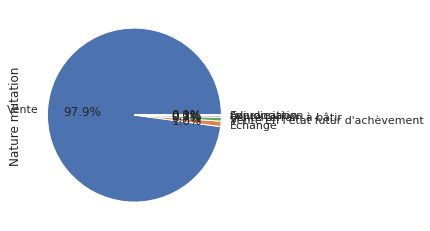

In [ ]:
df_immo_full['Nature mutation'].value_counts().plot.pie(autopct="%.1f%%")

## Verification

In [ ]:
df_immo_full[df_immo_full['Surface reelle bati'].notna() & df_immo_full['Type local'].isna()].shape

(0, 23)

In [ ]:
df_immo_full[df_immo_full['Surface reelle bati'].isna() & df_immo_full['Type local'].notna()]

,No disposition,Date mutation,Nature mutation,Valeur fonciere,No voie,Type de voie,Code voie,Voie,Code postal,Commune,Code departement,Code commune,Section,No plan,1er lot,Surface Carrez du 1er lot,Nombre de lots,Code type local,Type local,Surface reelle bati,Nombre pieces principales,Nature culture,Surface terrain
1511695,1,2020-08-24,Vente,714000.0,11,RUE,0603,DES PLANQUETTES,62217,ACHICOURT,62,4,AX,11,NaN,NaN,0,4.0,Local industriel. commercial ou assimilé,NaN,<NA>,S,5900.0
515737,1,2020-04-09,Vente,150000.0,126,RUE,0060,DE PACY,27400,ACQUIGNY,27,3,ZD,362,NaN,NaN,0,4.0,Local industriel. commercial ou assimilé,NaN,<NA>,S,4430.0
1664900,1,2020-09-26,Vente,30000.0,8,NaN,B120,FORGES DE LA BRANLEURE,70320,AILLEVILLERS-ET-LYAUMONT,70,6,A,1611,NaN,NaN,0,4.0,Local industriel. commercial ou assimilé,NaN,<NA>,S,1554.0
1522008,1,2020-12-28,Vente,560000.0,5003,NaN,X011,ZAL DES CHAMPS DU CLER,62160,AIX NOULETTE,62,19,AE,334,NaN,NaN,0,4.0,Local industriel. commercial ou assimilé,NaN,<NA>,S,6583.0
2101485,1,2020-12-03,Vente,158300.0,9012,RUE,0008,D ARLIQUET,87700,AIXE-SUR-VIENNE,87,1,AH,52,NaN,NaN,0,4.0,Local industriel. commercial ou assimilé,NaN,<NA>,S,102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391597,1,2020-06-25,Vente,465000.0,4,ALL,0059,DE LA CLAIRIERE,59136,WAVRIN,59,653,AP,69,NaN,NaN,0,4.0,Local industriel. commercial ou assimilé,NaN,<NA>,S,2500.0
400082,1,2020-12-10,Vente,1900000.0,6,RUE,0150,DE L ECLUSE,22120,YFFINIAC,22,389,AP,18,NaN,NaN,0,4.0,Local industriel. commercial ou assimilé,NaN,<NA>,S,5000.0
400083,1,2020-12-10,Vente,1900000.0,4,RUE,0150,DE L ECLUSE,22120,YFFINIAC,22,389,AP,19,NaN,NaN,0,4.0,Local industriel. commercial ou assimilé,NaN,<NA>,S,5000.0
691080,1,2020-06-23,Vente,243529.3,3,NaN,B085,ZA DU GRAND CHEMIN,33370,YVRAC,33,554,C,1411,NaN,NaN,0,4.0,Local industriel. commercial ou assimilé,NaN,<NA>,S,2070.0


In [ ]:
df_immo_full[df_immo_full['Surface reelle bati'].isna() & df_immo_full['Type local'].notna() & df_immo_full['Surface terrain'].isna()].shape

(0, 23)

In [ ]:
# Peut etre a drop
df_immo_full[df_immo_full['Surface reelle bati'].isna() & df_immo_full['Type local'].notna() & df_immo_full['Nombre pieces principales'].isna()]

In [ ]:
df_immo_full[df_immo_full['Surface reelle bati'].isna() & df_immo_full['Nombre pieces principales'].notna()].shape


(0, 23)

In [ ]:
df_immo_full[df_immo_full['Surface reelle bati'].notna() & df_immo_full['Nombre pieces principales'].isna()].shape

(0, 23)

In [ ]:
df_immo_full[df_immo_full['Surface terrain'].notna() & df_immo_full['Nombre pieces principales'].notna()].shape

(1661061, 23)

In [ ]:
df_immo_full[df_immo_full['Surface terrain'].isna() & df_immo_full['Surface terrain'].isna()]

,No disposition,Date mutation,Nature mutation,Valeur fonciere,No voie,Type de voie,Code voie,Voie,Code postal,Commune,Code departement,Code commune,Section,No plan,1er lot,Surface Carrez du 1er lot,Nombre de lots,Code type local,Type local,Surface reelle bati,Nombre pieces principales,Nature culture,Surface terrain
14,1,2020-06-01,Vente,54800.0,6,AV,0770,DU CHAMP DE FOIRE,1000,BOURG-EN-BRESSE,01,53,BK,197,211,"31,68",2,2.0,Appartement,32.0,1,NaN,NaN
24,1,2020-01-13,Vente,97000.0,16,RUE,1770,DES GRAVES,1000,BOURG-EN-BRESSE,01,53,AZ,476,8,"78,03",1,2.0,Appartement,92.0,3,NaN,NaN
34,1,2020-07-01,Vente,96000.0,10,ALL,3044,DE LA PETITE REYSSOUZE,1000,BOURG-EN-BRESSE,01,53,BD,227,134,NaN,1,3.0,Dépendance,0.0,0,NaN,NaN
35,1,2020-07-01,Vente,96000.0,12,ALL,3044,DE LA PETITE REYSSOUZE,1000,BOURG-EN-BRESSE,01,53,BD,227,20,"74,07",2,2.0,Appartement,74.0,3,NaN,NaN
47,1,2020-09-01,Vente,99000.0,18,RUE,1770,DES GRAVES,1000,BOURG-EN-BRESSE,01,53,AZ,476,22,"91,47",1,2.0,Appartement,91.0,4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2254722,1,2020-12-23,Vente,1.0,37,RUE,9318,TIQUETONNE,75002,PARIS 02,75,102,AL,124,26,NaN,1,2.0,Appartement,31.0,2,NaN,NaN
2254723,1,2020-12-29,Vente,355000.0,40,RUE,9382,DES TOURNELLES,75004,PARIS 04,75,104,AO,93,6,NaN,1,2.0,Appartement,32.0,2,NaN,NaN
2254724,1,2020-12-29,Vente,151000.0,2,RUE,1223,BOUTAREL,75004,PARIS 04,75,104,AV,115,15,"9,64",1,2.0,Appartement,10.0,1,NaN,NaN
2254725,1,2020-12-23,Vente,160010.0,147,RUE,8525,SAINT-DENIS,75002,PARIS 02,75,102,AL,37,11,"12,71",1,2.0,Appartement,14.0,1,NaN,NaN


In [ ]:
df_immo_full[df_immo_full['Surface terrain']==0].shape

(59, 23)

In [ ]:
df_immo_full[df_immo_full['Surface reelle bati']==0]

,No disposition,Date mutation,Nature mutation,Valeur fonciere,No voie,Type de voie,Code voie,Voie,Code postal,Commune,Code departement,Code commune,Section,No plan,1er lot,Surface Carrez du 1er lot,Nombre de lots,Code type local,Type local,Surface reelle bati,Nombre pieces principales,Nature culture,Surface terrain
18,1,2020-03-01,Vente,350750.0,904,CHE,0149,DES GDES CADALLES,1000,SAINT-DENIS-LES-BOURG,01,344,AC,39,NaN,NaN,0,3.0,Dépendance,0.0,0,S,1497.0
19,1,2020-03-01,Vente,350750.0,904,CHE,0149,DES GDES CADALLES,1000,SAINT-DENIS-LES-BOURG,01,344,AC,39,NaN,NaN,0,3.0,Dépendance,0.0,0,J,1267.0
34,1,2020-07-01,Vente,96000.0,10,ALL,3044,DE LA PETITE REYSSOUZE,1000,BOURG-EN-BRESSE,01,53,BD,227,134,NaN,1,3.0,Dépendance,0.0,0,NaN,NaN
56,2,2020-08-01,Vente,150000.0,5134,NaN,B031,VAVRES,1340,MALAFRETAZ,01,229,A,755,NaN,NaN,0,3.0,Dépendance,0.0,0,S,746.0
58,2,2020-08-01,Vente,150000.0,5134,NaN,B031,VAVRES,1340,MALAFRETAZ,01,229,A,755,NaN,NaN,0,3.0,Dépendance,0.0,0,S,746.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2254655,1,2020-12-28,Vente,295000.0,103,RUE,0040,D ABOUKIR,75002,PARIS 02,75,102,AO,178,12,"33,00",1,3.0,Dépendance,0.0,0,NaN,NaN
2254670,1,2020-12-18,Vente,151200.0,11,RUE,0420,DES ARCHIVES,75004,PARIS 04,75,104,AF,36,40,NaN,1,3.0,Dépendance,0.0,0,NaN,NaN
2254697,1,2020-12-15,Vente,725000.0,12,RUE,3106,DES ECOUFFES,75004,PARIS 04,75,104,AI,70,34,NaN,1,3.0,Dépendance,0.0,0,NaN,NaN
2254740,1,2020-12-16,Vente,1937500.0,24,RUE,1748,CHANOINESSE,75004,PARIS 04,75,104,AW,19,NaN,NaN,0,3.0,Dépendance,0.0,0,S,447.0


In [ ]:
cond_a = (df_immo_full['Surface reelle bati']==0 | df_immo_full['Surface reelle bati'].isna())
cond_b = (df_immo_full['Surface terrain']==0 | df_immo_full['Surface terrain'].isna())

In [ ]:
df_immo_full[df_immo_full['Surface reelle bati']==0 | df_immo_full['Surface reelle bati'].isna()]

,No disposition,Date mutation,Nature mutation,Valeur fonciere,No voie,Type de voie,Code voie,Voie,Code postal,Commune,Code departement,Code commune,Section,No plan,1er lot,Surface Carrez du 1er lot,Nombre de lots,Code type local,Type local,Surface reelle bati,Nombre pieces principales,Nature culture,Surface terrain
18,1,2020-03-01,Vente,350750.0,904,CHE,0149,DES GDES CADALLES,1000,SAINT-DENIS-LES-BOURG,01,344,AC,39,NaN,NaN,0,3.0,Dépendance,0.0,0,S,1497.0
19,1,2020-03-01,Vente,350750.0,904,CHE,0149,DES GDES CADALLES,1000,SAINT-DENIS-LES-BOURG,01,344,AC,39,NaN,NaN,0,3.0,Dépendance,0.0,0,J,1267.0
34,1,2020-07-01,Vente,96000.0,10,ALL,3044,DE LA PETITE REYSSOUZE,1000,BOURG-EN-BRESSE,01,53,BD,227,134,NaN,1,3.0,Dépendance,0.0,0,NaN,NaN
56,2,2020-08-01,Vente,150000.0,5134,NaN,B031,VAVRES,1340,MALAFRETAZ,01,229,A,755,NaN,NaN,0,3.0,Dépendance,0.0,0,S,746.0
58,2,2020-08-01,Vente,150000.0,5134,NaN,B031,VAVRES,1340,MALAFRETAZ,01,229,A,755,NaN,NaN,0,3.0,Dépendance,0.0,0,S,746.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2254655,1,2020-12-28,Vente,295000.0,103,RUE,0040,D ABOUKIR,75002,PARIS 02,75,102,AO,178,12,"33,00",1,3.0,Dépendance,0.0,0,NaN,NaN
2254670,1,2020-12-18,Vente,151200.0,11,RUE,0420,DES ARCHIVES,75004,PARIS 04,75,104,AF,36,40,NaN,1,3.0,Dépendance,0.0,0,NaN,NaN
2254697,1,2020-12-15,Vente,725000.0,12,RUE,3106,DES ECOUFFES,75004,PARIS 04,75,104,AI,70,34,NaN,1,3.0,Dépendance,0.0,0,NaN,NaN
2254740,1,2020-12-16,Vente,1937500.0,24,RUE,1748,CHANOINESSE,75004,PARIS 04,75,104,AW,19,NaN,NaN,0,3.0,Dépendance,0.0,0,S,447.0


In [ ]:
exclude = [0 ,np.nan]
df_immo_full[df_immo_full['Surface reelle bati'].isin(exclude)]
df_immo_full[df_immo_full['Surface terrain'].isin(exclude)]
df_immo_full[df_immo_full['Surface terrain'].isin(exclude) & df_immo_full['Surface reelle bati'].isin(exclude)]


,No disposition,Date mutation,Nature mutation,Valeur fonciere,No voie,Type de voie,Code voie,Voie,Code postal,Commune,Code departement,Code commune,Section,No plan,1er lot,Surface Carrez du 1er lot,Nombre de lots,Code type local,Type local,Surface reelle bati,Nombre pieces principales,Nature culture,Surface terrain
34,1,2020-07-01,Vente,96000.0,10,ALL,3044,DE LA PETITE REYSSOUZE,1000,BOURG-EN-BRESSE,01,53,BD,227,134,NaN,1,3.0,Dépendance,0.0,0,NaN,NaN
123,1,2020-01-16,Vente,101300.0,86,AV,0260,DE LYON,1960,PERONNAS,01,289,AC,47,33,NaN,1,3.0,Dépendance,0.0,0,NaN,NaN
148,1,2020-01-17,Vente,125000.0,47,AV,2420,MAGINOT,1000,BOURG-EN-BRESSE,01,53,AC,523,33,NaN,1,3.0,Dépendance,0.0,0,NaN,NaN
150,1,2020-01-17,Vente,105000.0,12,RUE,1070,DE CUIRON,1000,BOURG-EN-BRESSE,01,53,AV,44,165,NaN,1,3.0,Dépendance,0.0,0,NaN,NaN
161,1,2020-01-20,Vente,8000.0,4,PL,3090,PIERRE GOUJON,1000,BOURG-EN-BRESSE,01,53,AD,483,65,NaN,1,3.0,Dépendance,0.0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2254633,1,2020-12-29,Vente,170000.0,36,BD,4583,HENRI IV,75004,PARIS 04,75,104,AP,82,24,"12,84",1,3.0,Dépendance,0.0,0,NaN,NaN
2254640,1,2020-12-28,Vente,1350000.0,18,RUE,2774,DES DEUX PONTS,75004,PARIS 04,75,104,AV,28,74,NaN,1,3.0,Dépendance,0.0,0,NaN,NaN
2254655,1,2020-12-28,Vente,295000.0,103,RUE,0040,D ABOUKIR,75002,PARIS 02,75,102,AO,178,12,"33,00",1,3.0,Dépendance,0.0,0,NaN,NaN
2254670,1,2020-12-18,Vente,151200.0,11,RUE,0420,DES ARCHIVES,75004,PARIS 04,75,104,AF,36,40,NaN,1,3.0,Dépendance,0.0,0,NaN,NaN


In [ ]:
df_immo_full.head(8)

,No disposition,Date mutation,Nature mutation,Valeur fonciere,No voie,Type de voie,Code voie,Voie,Code postal,Commune,Code departement,Code commune,Section,No plan,1er lot,Surface Carrez du 1er lot,Nombre de lots,Code type local,Type local,Surface reelle bati,Nombre pieces principales,Nature culture,Surface terrain
0,1,2020-07-01,Vente,8000.0,<NA>,NaN,B063,FORTUNAT,1250,CEYZERIAT,01,72,AK,216,NaN,NaN,0,NaN,none,NaN,<NA>,T,1061.0
1,1,2020-02-01,Vente,2175.0,<NA>,NaN,B124,TERRES DES CINQ SAULES,1290,LAIZ,01,203,B,4,NaN,NaN,0,NaN,none,NaN,<NA>,BT,85.0
2,1,2020-02-01,Vente,2175.0,<NA>,NaN,B006,BOIS DU CHAMP RION,1290,LAIZ,01,203,B,173,NaN,NaN,0,NaN,none,NaN,<NA>,T,1115.0
3,1,2020-02-01,Vente,2175.0,<NA>,NaN,B025,EN COROBERT,1290,LAIZ,01,203,B,477,NaN,NaN,0,NaN,none,NaN,<NA>,T,1940.0
4,1,2020-02-01,Vente,2175.0,<NA>,NaN,B124,TERRES DES CINQ SAULES,1290,LAIZ,01,203,C,68,NaN,NaN,0,NaN,none,NaN,<NA>,T,1148.0
5,1,2020-02-01,Vente,2175.0,<NA>,NaN,B124,TERRES DES CINQ SAULES,1290,LAIZ,01,203,C,69,NaN,NaN,0,NaN,none,NaN,<NA>,T,2960.0
6,1,2020-07-01,Vente,75000.0,<NA>,RUE,0064,DE LA CHARTREUSE,1960,PERONNAS,01,289,AI,210,NaN,NaN,0,NaN,none,NaN,<NA>,AB,610.0
7,1,2020-07-01,Vente,123.0,<NA>,NaN,B041,CHAMP PORTIER,1370,VAL-REVERMONT,01,426,ZN,197,NaN,NaN,0,NaN,none,NaN,<NA>,S,55.0


In [ ]:
nan_rate(df_immo_full)

No disposition               0.000000
Date mutation                0.000000
Nature mutation              0.000000
Valeur fonciere              0.000000
No voie                      0.390926
Type de voie                 0.415932
Code voie                    0.000000
Voie                         0.000071
Code postal                  0.000000
Commune                      0.000000
Code departement             0.000000
Code commune                 0.000000
Section                      0.000035
No plan                      0.000000
1er lot                      0.738148
Surface Carrez du 1er lot    0.911152
Nombre de lots               0.000000
Code type local              0.422683
Type local                   0.000000
Surface reelle bati          0.422683
Nombre pieces principales    0.000000
Nature culture               0.263304
Surface terrain              0.263304
dtype: float64

In [ ]:
df_immo_full['Nature culture'].value_counts().shape

(27,)

In [ ]:
df_immo_full['Nature culture']

## Managing Type local

In [ ]:
df_immo_full['Type local'].value_counts()

none                                        951682
Maison                                      526142
Appartement                                 389435
Local industriel. commercial ou assimilé     81301
Dépendance                                   63478
Name: Type local, dtype: int64

In [ ]:
df_immo_full['Type local'] =df_immo_full['Type local'].fillna('none')
df_immo_full_cat = df_immo_full[['Type local']]
from sklearn.preprocessing import OneHotEncoder
cat_local = OneHotEncoder(handle_unknown='ignore')
#cat_local.fit(df_immo_full['Type local'].values.reshape(-1, 1))
df_immo_1hot = cat_local.fit_transform(df_immo_full_cat)
df_1hot = pd.DataFrame(df_immo_1hot.toarray(), columns = ['is_'+i for i in cat_local.categories_[0]])

In [ ]:
cat_local.categories_[0]

array(['Appartement', 'Dépendance',
       'Local industriel. commercial ou assimilé', 'Maison', 'none'],
      dtype=object)

In [ ]:
df_1hot

,is_Appartement,is_Dépendance,is_Local industriel. commercial ou assimilé,is_Maison,is_none
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
2256138,1.0,0.0,0.0,0.0,0.0
2256139,0.0,1.0,0.0,0.0,0.0
2256140,1.0,0.0,0.0,0.0,0.0
2256141,0.0,1.0,0.0,0.0,0.0


In [ ]:
nan_rate(df_1hot)

is_Appartement                                 0.0
is_Dépendance                                  0.0
is_Local industriel. commercial ou assimilé    0.0
is_Maison                                      0.0
is_none                                        0.0
dtype: float64

In [ ]:
nan_rate(df_immo_full)

No disposition               0.000000
Date mutation                0.000000
Nature mutation              0.000000
Valeur fonciere              0.000000
No voie                      0.390702
Type de voie                 0.415874
Code voie                    0.000000
Voie                         0.000071
Code postal                  0.000000
Commune                      0.000000
Code departement             0.000000
Code commune                 0.000000
Section                      0.000035
No plan                      0.000000
1er lot                      0.738310
Surface Carrez du 1er lot    0.911207
Nombre de lots               0.000000
Code type local              0.422420
Type local                   0.000000
Surface reelle bati          0.423041
Nombre pieces principales    0.423041
Nature culture               0.263141
Surface terrain              0.263141
dtype: float64

<bound method DataFrame.reset_index of          No disposition Date mutation  ... Nature culture  Surface terrain
1572789               1    2020-01-21  ...              T           8497.0
1572864               1    2020-07-02  ...              S            631.0
1572865               1    2020-07-02  ...              J           1000.0
1578466               1    2020-09-07  ...              T           1310.0
1578467               1    2020-09-07  ...              T           8640.0
...                 ...           ...  ...            ...              ...
1421444               1    2020-06-08  ...              S            664.0
1421899               1    2020-01-10  ...              T          27380.0
1421900               1    2020-01-10  ...              T          55110.0
1421901               1    2020-01-10  ...              T            225.0
1422104               2    2020-10-20  ...              T           3430.0

[2256143 rows x 23 columns]>

In [ ]:
for i in [df_immo_full, df_1hot]:
  print (i.shape)

(2256143, 23)
(2256143, 5)


In [ ]:
df_immo = pd.concat([df_immo_full, df_1hot], axis=1)

In [ ]:
df_immo.shape

(2256143, 28)

In [ ]:
df_immo_full['Code type local'].value_counts()

1.0    526142
2.0    389435
4.0     81301
3.0     63478
Name: Code type local, dtype: int64

## Statistical Outliers

In [ ]:
my_zscore = zscore(df_immo_full['Valeur fonciere'])
my_zscore[(abs(my_zscore)>2)].index


Int64Index([  78303,   78304,   78305,   79864,   79865,   79866,   79867,
              79868,   79869,   79870,
            ...
            2024870, 2024871, 2024872, 2024873, 2024874, 2024875, 2024876,
            2024877, 2024878, 2024879],
           dtype='int64', length=13031)

In [ ]:
df_vf.loc[df_vf['Valeur fonciere']<500]

# Segmentation

### Overview

In [ ]:
reg_col = ['Valeur fonciere','Nombre de lots','Surface reelle bati',
  'Nombre pieces principales','Surface terrain','is_Appartement', 'is_Dépendance','is_Maison', 'is_none']

In [ ]:
df_reg = df_immo_1hot[reg_col]
datas = df_reg

In [ ]:
#'Date mutation'

## Kmeans Simple

In [ ]:
 from sklearn.cluster import KMeans

In [ ]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(datas)
    distortions.append(kmeanModel.inertia_)

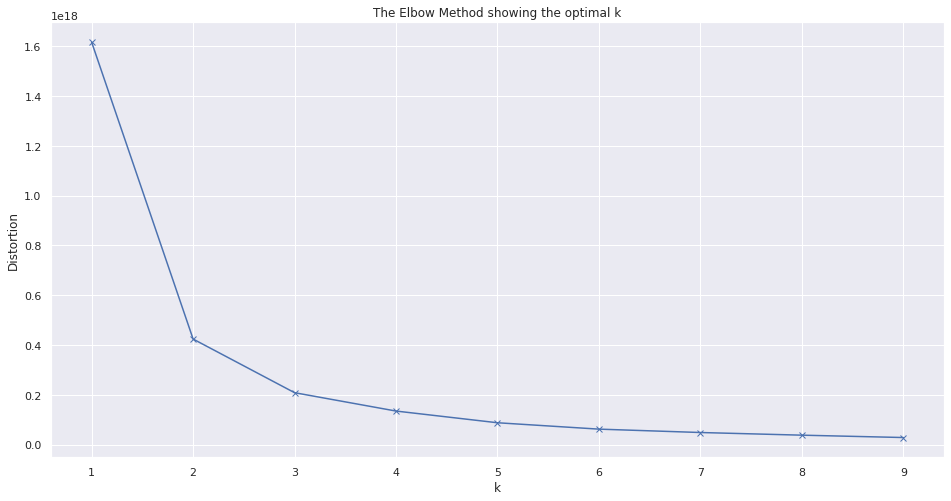

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
my_kmeans = KMeans(n_clusters=3)
my_kmeans.fit(datas)
distortions.append(my_kmeans.inertia_)

In [ ]:
my_kmeans.cluster_centers_

array([[1.92561360e+05, 2.77468083e-01, 5.19621143e+01, 1.61737726e+00,
        2.20361984e+03, 1.89708126e-01, 3.00242973e-02, 2.66356303e-01,
        4.77075675e-01],
       [9.49802773e+06, 2.79522803e-01, 1.77762156e+02, 1.50415282e+00,
        6.56258374e+03, 4.71836303e-01, 1.58788886e-01, 4.63606161e-02,
        1.38779825e-01],
       [2.93881499e+06, 3.32072895e-01, 1.84937556e+02, 1.34297043e+00,
        5.27217176e+03, 2.94706160e-01, 6.58053674e-02, 8.61299302e-02,
        3.79076729e-01]])

## Kmeans on each month

## Hierarchical Clustering

In [ ]:
datas = df_reg.sample(n=20000)

In [ ]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



Text(0.5, 0, 'Number of points in node (or index of point if no parenthesis).')

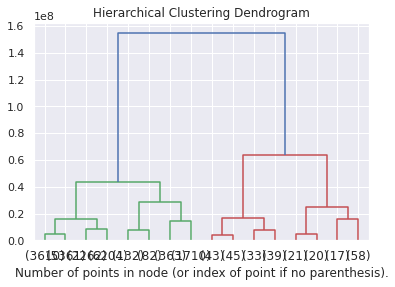

In [ ]:
X = datas

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
y_pred = AgglomerativeClustering(n_clusters = 3).fit_predict()

# Visualisation du résultat
plt.figure(figsize = (5,5))
plt.scatter(X['abscisse'],X['ordonnée'],c = y_pred);

# Start IA Regressions

### Overview

### Overview2 only maison appart

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold

from sklearn import ensemble
from sklearn.inspection import permutation_importance

In [27]:
def scores(model):
    y_train_predict = model.predict(X_test)
    rmse = (np.sqrt(mean_squared_error(y_test, y_test_predict)))
    r2 = r2_score(y_test, y_test_predict)
    mae = mean_absolute_error(y_test, y_test_predict)
    N = int(X_test.shape[0])
    p = int(X_test.shape[1])
    r2_adjusted = 1-((1-r2)*(N-1))/(N-p-1)
    return print('rmse is',rmse,'\nr2 is',r2,'\nmae is ', mae,'\nr2 ajusted is',r2_adjusted)

In [28]:
templist = ['Maison','Appartement']
df_onlyma = df_immo_1hot[df_immo_1hot['Type local'].isin(templist)]
df_onlyma.shape

(915577, 27)

In [40]:
reg_col = ['Valeur fonciere','Nombre de lots','Surface reelle bati',
  'Nombre pieces principales','Surface terrain','is_Maison']

In [70]:
df_reg = df_onlyma[reg_col].sample(n = 2000)

In [71]:
my_zscore = zscore(df_reg['Valeur fonciere'])
df_reg.drop(my_zscore[(abs(my_zscore)>2)].index, inplace=True)

In [72]:
X = df_reg.drop(columns='Valeur fonciere')
y = df_reg['Valeur fonciere']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state = 42)

## Qu'y a t'il dedans??

In [63]:
df_reg

,Valeur fonciere,Nombre de lots,Surface reelle bati,Nombre pieces principales,Surface terrain,is_Maison
1448464,380000.0,0,190.0,4,1057.0,1.0
1174296,325000.0,1,36.0,2,0.0,0.0
408866,62000.0,0,60.0,3,823.0,1.0
194720,150000.0,0,34.0,2,55.0,0.0
1300835,110200.0,0,111.0,5,122.0,1.0
...,...,...,...,...,...,...
221461,152500.0,0,107.0,5,427.0,1.0
1117844,220000.0,0,94.0,4,14112.0,1.0
1620070,203000.0,0,87.0,4,319.0,1.0
158130,135000.0,0,90.0,4,305.0,1.0


## Reg No Scaler

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state = 42)
reg=LinearRegression()
reg.fit(X_train,y_train)
y_test_predict = reg.predict(X_test)
scores(reg)

rmse is 224109.86281964296 
r2 is 0.15920290217669752 
mae is  137209.0985580954 
r2 ajusted is 0.1526546381749585


## Reg MinMax Scaler

In [64]:
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.33,random_state = 42)
reg=LinearRegression()
reg.fit(X_train,y_train)
y_test_predict = reg.predict(X_test)
scores(reg)

rmse is 203772.1783731575 
r2 is 0.11560035553828307 
mae is  130346.23906329236 
r2 ajusted is 0.11491752690605495


## Reg Standard Scaler

In [57]:
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.33,random_state = 42)
reg=LinearRegression()
reg.fit(X_train,y_train)
y_test_predict = reg.predict(X_test)
scores(reg)

rmse is 223479.79571734017 
r2 is 0.09360038686685357 
mae is  135646.95838487826 
r2 ajusted is 0.0934605492271341


## Ridge Regression

In [75]:
from sklearn.model_selection import GridSearchCV

model = Ridge()
# define evaluation
cv = RepeatedKFold(n_splits=5, n_repeats=3)
# define search space
space = dict()
space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
space['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
space['fit_intercept'] = [True, False]
space['normalize'] = [True, False]
# define search
search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)
# execute search
result = search.fit(X, y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -132511.0595452173
Best Hyperparameters: {'alpha': 0.1, 'fit_intercept': True, 'normalize': True, 'solver': 'svd'}


In [77]:
model = Ridge(alpha= 0.01, fit_intercept= True, normalize= True, solver= 'sag' )
model.fit(X_train,y_train)
y_test_predict = model.predict(X_test)
scores(model)

rmse is 224215.83046615758 
r2 is 0.15840759265465332 
mae is  137122.2882539361 
r2 ajusted is 0.15185313465352135


## XGBoost

In [74]:
params = {'n_estimators': 500,
          'max_depth': 4 ,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
xg = ensemble.GradientBoostingRegressor(**params)
xg.fit(X_train, y_train)
y_test_predict = xg.predict(X_test)
scores(xg)

rmse is 219927.45153540326 
r2 is 0.1902925261530396 
mae is  133399.8468581718 
r2 ajusted is 0.18398639317915366
